<a href="https://colab.research.google.com/github/seon-pegado/Deep-Learning/blob/master/Potato_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
BATCH_SIZE  = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

## Loading the Dataset :
* Reshaping it to (256,256)
* color channel is 3

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Potato Leaf Disease/Training',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    seed = 42,
    batch_size = BATCH_SIZE
)

Found 3251 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
len(dataset)

102

In [6]:
102*BATCH_SIZE

3264

Here the last batch is not completely filled upto it batch size of 32

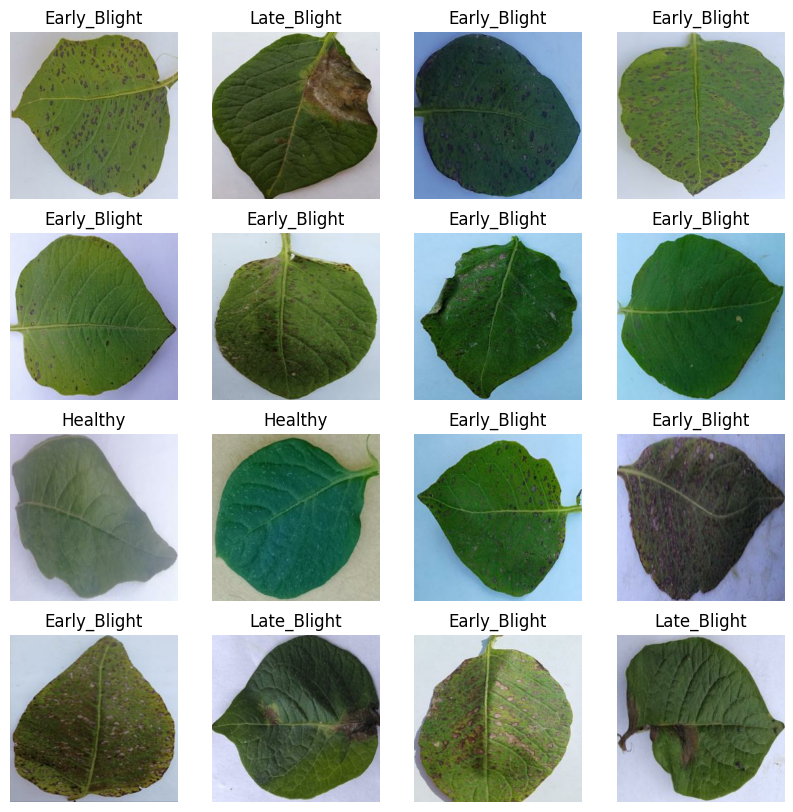

In [7]:
fig = plt.figure(figsize = (10,10))
np.random.seed(42)
for image_batch, label_batch in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_name[label_batch[i]])

### Splitting the data:
* 80% ==> training
* 20% ==> 10% => validation & 10% => testing

In [8]:
len(dataset)*0.8 # training split

81.60000000000001

In [9]:
train_ds = dataset.take(81)
len(train_ds)

81

In [10]:
test_ds = dataset.skip(81)
len(test_ds)

21

In [11]:
len(dataset)*0.1 # validation split

10.200000000000001

In [12]:
valid_ds = test_ds.take(10)
len(valid_ds)

10

In [13]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [14]:
81+10+11 # Check for the length of dataset

102

Creating a function for the splitting the data

In [15]:
def create_split(ds, train_split=0.8, valid_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed= 42)

  ds_size = len(ds)
  train_size = int(ds_size * train_split)
  valid_size = int(ds_size * valid_split)

  train_ds = ds.take(train_size)
  test_ds = ds.skip(train_size)
  valid_ds = test_ds.take(valid_size)
  test_ds = test_ds.skip(valid_size)

  return train_ds, valid_ds, test_ds


In [16]:
train_ds, valid_ds, test_ds = create_split(dataset)

In [17]:
len(train_ds), len(valid_ds), len(test_ds)

(81, 10, 11)

In [18]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
resize_rescale = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [20]:
data_augmentation = keras.models.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = keras.models.Sequential([
    resize_rescale,
    data_augmentation,
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    keras.layers.MaxPooling2D(pool_size= (2,2)),
    keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 3, activation = 'softmax')
])

In [22]:
model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [25]:
history = model.fit(x = train_ds, epochs = EPOCHS, validation_data = valid_ds)

Epoch 1/50
81/81 [==============================] - 29s 139ms/step - loss: 1.0318 - accuracy: 0.4699 - val_loss: 0.8475 - val_accuracy: 0.6250
Epoch 2/50
81/81 [==============================] - 15s 128ms/step - loss: 0.8307 - accuracy: 0.6320 - val_loss: 0.7711 - val_accuracy: 0.6313
Epoch 3/50
81/81 [==============================] - 14s 118ms/step - loss: 0.7287 - accuracy: 0.7079 - val_loss: 0.5618 - val_accuracy: 0.8031
Epoch 4/50
81/81 [==============================] - 14s 116ms/step - loss: 0.6135 - accuracy: 0.7766 - val_loss: 0.5866 - val_accuracy: 0.7625
Epoch 5/50
81/81 [==============================] - 14s 121ms/step - loss: 0.5756 - accuracy: 0.7763 - val_loss: 0.5125 - val_accuracy: 0.8406
Epoch 6/50
81/81 [==============================] - 13s 113ms/step - loss: 0.5073 - accuracy: 0.8135 - val_loss: 0.3265 - val_accuracy: 0.8969
Epoch 7/50
81/81 [==============================] - 14s 121ms/step - loss: 0.4653 - accuracy: 0.8360 - val_loss: 0.4440 - val_accuracy: 0.8594

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 81}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['accuracy']

[0.4699496030807495,
 0.6320279240608215,
 0.7079475522041321,
 0.7766203880310059,
 0.7762698531150818,
 0.8134936094284058,
 0.8359829187393188,
 0.8390849232673645,
 0.8573090434074402,
 0.8770841360092163,
 0.8449074029922485,
 0.8774718642234802,
 0.903063178062439,
 0.8545948266983032,
 0.9088793992996216,
 0.8840636014938354,
 0.9046142101287842,
 0.892981767654419,
 0.9081039428710938,
 0.9162465929985046,
 0.9309809803962708,
 0.9236137866973877,
 0.9208995699882507,
 0.8592477440834045,
 0.905389666557312,
 0.9270833134651184,
 0.9320987462997437,
 0.9336952567100525,
 0.892981767654419,
 0.9425154328346252,
 0.945327639579773,
 0.9367972016334534,
 0.9383481740951538,
 0.9018999338150024,
 0.9506173133850098,
 0.9461031556129456,
 0.9430011510848999,
 0.945327639579773,
 0.9565722942352295,
 0.9560185074806213,
 0.9569600820541382,
 0.945327639579773,
 0.9243893027305603,
 0.9290123581886292,
 0.9567901492118835,
 0.9620007872581482,
 0.9670414924621582,
 0.9594907164573669,

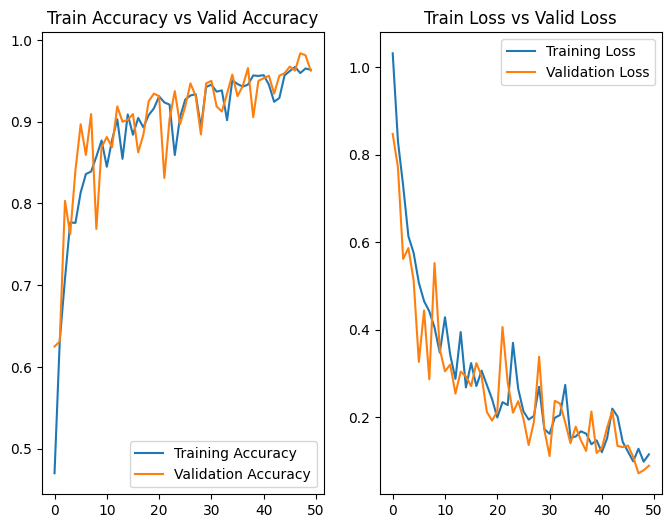

In [39]:
plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Train Accuracy vs Valid Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), history.history['loss'], label = 'Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Train Loss vs Valid Loss');

In [40]:
model.evaluate(test_ds)

11/11 [==============================] - 6s 35ms/step - loss: 0.1161 - accuracy: 0.9659


[0.11614806205034256, 0.9659090638160706]